Read input data from all directories into pandas data frame. Input data is divided into three directories, all of these contain data for Track1 only
1. Center folder contains images with central (tried my best) driving with 3-4 rounds around the track
2. Recovery folder contains recording of recovery images where car moves away from the corners. This helps to recover from cases where car accidently lands into corners of the track.
3. Reverse folder contains images with 2 rounds around the track, but in reverse direction. This helps reduce inherent left turn biases in the track.

In [1]:
# Read input samples
import numpy as np
import pandas as pd

DIR_PREFIX="../TrainingData/Track1/"
training_dirs = ["Center", "Reverse", "Recovery", "Recovery-More", "Bridge"]

csv_list = []
for one_dir in training_dirs:
    one_sample = pd.read_csv(DIR_PREFIX + one_dir + "/driving_log.csv", header=None, delimiter=',')
    csv_list.append(one_sample)
samples = pd.concat(csv_list)
samples.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']

In [2]:
samples.head()

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000080
1,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000079
2,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000079
3,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000078
4,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000078


Following plot shows steering angle distribution of input data, majority of steering angles are close to 0

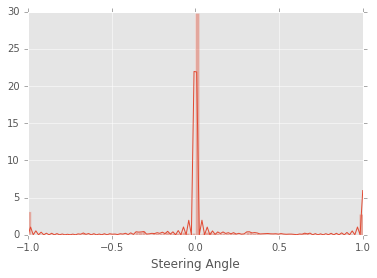

In [3]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns

style.use('ggplot')

fig, ax = plt.subplots()
_ = sns.distplot(samples['Steering Angle'], bins=100)

Split above sample images into 80% training and 20% validation datasets, shuffle these samples before split.

In [4]:
# Split samples into train and test
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2, shuffle=True)
print(train_samples.shape[0])
print(validation_samples.shape[0])

8167
2042


Below image preporcessing steps helps generalize the model to an unseen track

In [5]:
import cv2

# Adjust brightness of image
def adjust_brightness(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype=np.float32)
    image[:,:,2] = image[:,:,2] * (0.5 + np.random.uniform())
    image[:,:,2][image[:,:,2] > 255] = 255
    image = np.array(image, dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

def translate_image(image, steer_angle):
    # Assuming the image x-axis covers angle range [-1.0, 1.0] which has
    # absolute lenght of 2.0, we can calculate per pixel change in steering
    # angle like this
    steer_per_px = 2.0/image.shape[1]
    tx = 100*(np.random.uniform()-0.5)
    steer_angle += tx*steer_per_px
    ty = 40*(np.random.uniform()-0.5)
    TransMat = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image,TransMat,(image.shape[1],image.shape[0]))
    return image, steer_angle

def preprocess_image(image, steer_angle):
    # Randomly flip image left-right
    if np.random.randint(2) == 1:
        image = np.fliplr(image)
        steer_angle = -steer_angle
    image = adjust_brightness(image)
    image, steer_angle = translate_image(image, steer_angle)
    return (image, steer_angle)

Lets try out these transformations on randomly selected image

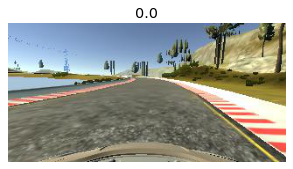

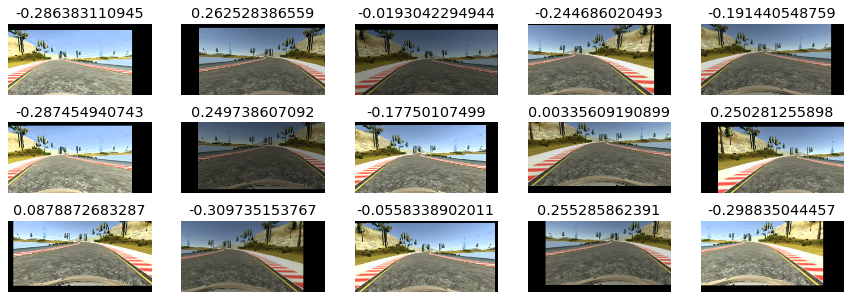

In [6]:
from PIL import Image

# Randomly select a sample image and perform images transformations
idx = np.random.randint(samples.shape[0])
angle = samples.iloc[idx]['Steering Angle']
dir_splits = samples.iloc[idx]['Center Image'].split('/')
img_file = DIR_PREFIX + dir_splits[-3] + '/IMG/' + dir_splits[-1]
image = np.asarray(Image.open(img_file))
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.title(angle)
plt.figure(figsize=(15,5))
n_images = 15
n_col = 5
n_row = (n_images + n_col - 1)//n_col
for i in range(n_images):
    processed_image, processed_angle = preprocess_image(image, angle)
    plt.subplot(n_row, n_col, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(processed_image)
    plt.title(processed_angle)

To limit amount of memory required to train the model, we use batch size of 32 for input images.

In [7]:
# Constants
BATCH_SIZE=32

# Input image dimensions
height, width, channel = (160, 320, 3)

Using generator help with limiting memory consumption to train the model as it reads files from disk in smaller batches and applies preprocessing to create more images. Having a bounded batch size can limit amount of memory needed.

Below generator implements following cruisial augmentation which helps generalize model to new tracks as well:
1. Input data is highly biased towards smaller steering angles. This bias can lead car to topple over a curve as model is biased to suggest smaller steering angles. Generator would eliminate data with absolute angle value < 0.1 with 70% drop off probability.
2. Besides center images, generators will also use left and right camera images and update corresponding steering angle with +0.25 and -0.25 delta respectively. This helps in training model for horizontally shifted images.
3. Flip images horizontally and negating corresponding steering angle. This helps training model for both left and right turns.


In [8]:
import sklearn
from sklearn.utils import shuffle

# Generator to get random batch of samples
def generator(samples, training=False, batch_size=BATCH_SIZE):
    n_samples = samples.shape[0]
    small_angle_threshold = 0.2
    small_angle_prob = 0.3
    angle_correction = 0.2
    while True:
        shuffle(samples)
        for offset in range(0, n_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            assert(batch_samples.shape[0] > 0)
            images = []
            angles = []
            for idx, one_sample in batch_samples.iterrows():
                angle = float(one_sample['Steering Angle'])
                camera_loc = 'Center Image'
                # If steering angle is too small, randomly choose left or right camera image
                # and adjust steering angle accordingly
                if (training == True) and (abs(angle) < small_angle_threshold) and \
                   (np.random.uniform() > small_angle_prob):
                    i = np.random.randint(2)
                    if i == 0:
                        camera_loc = 'Left Image'
                        angle += angle_correction
                    else:
                        camera_loc = 'Right Image'
                        angle -= angle_correction
    
                dir_splits = one_sample[camera_loc].split('/')
                img_file = DIR_PREFIX + dir_splits[-3] + '/IMG/' + dir_splits[-1]
                cam_img = np.asarray(Image.open(img_file))
                assert(cam_img.shape == (height, width, channel))

                images.append(cam_img)
                angles.append(angle)
                
                # create more example images with augmentations
                if training == True:
                    for i in range(5):
                        processed_img, processed_angle = preprocess_image(cam_img, angle)
                        images.append(processed_img)
                        angles.append(processed_angle)

            assert(len(images) != 0)

            # Generators use coroutine yield so that it can resume  back from yeild point
            # on next invocation
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

train_generator = generator(train_samples,training=True)
validation_generator = generator(validation_samples)

Following Model implements [NVIDIA's CNN pipeline](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) with following additions:
1. First layer is lambda layer to normalize Input images
2. Second layer crops camera images to cut off unwanted top and bottom portion of images that contains just noise e.g. sky, trees, mountain images in top portion and car dashboar images at the bottom.
3. Third layer resizes input images to 64x64 pixels, this significantly cuts down time to train easily by 10x.
4. Dropout layers with 50% probability after each fully connect layer (except for last). Dropout avoid overfitting of the model to input data set.
5. Using ELU activation function to avoid diminishing gradient problem.

Reason we do these image processing in keras layers is to modify images on fly and not having edit drive.py file

In [9]:
# Model Definition
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Lambda, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
import keras.backend as K
from keras.backend import tf as ktf

sess = ktf.Session(config=ktf.ConfigProto(intra_op_parallelism_threads=8))
K.set_session(sess)
K.set_image_data_format('channels_last')

def resize_image(image):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(image, (64, 64))

my_model = Sequential()
my_model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(height, width, channel)))
my_model.add(Cropping2D(cropping=((70, 25), (0, 0))))
my_model.add(Lambda(resize_image, input_shape=(height, width, channel), output_shape=(64, 64, channel)))
my_model.add(Conv2D(24, kernel_size=5, strides=2, activation='elu'))
my_model.add(Conv2D(36, kernel_size=5, strides=2, activation='elu'))
my_model.add(Conv2D(48, kernel_size=5, strides=2, activation='elu'))
my_model.add(Conv2D(64, kernel_size=3, activation='elu'))
my_model.add(Conv2D(64, kernel_size=3, activation='elu'))
my_model.add(Flatten())
my_model.add(Dense(100))
my_model.add(Dropout(0.5))
my_model.add(Dense(50))
my_model.add(Dropout(0.5))
my_model.add(Dense(10))
my_model.add(Dropout(0.5))
my_model.add(Dense(1))
my_model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          27712     
__________

Train the model using model.fit_generator method

In [10]:
my_model.compile(loss='mse', optimizer='adam')
train_steps = (train_samples.shape[0] + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (validation_samples.shape[0] + BATCH_SIZE - 1) // BATCH_SIZE
#train_steps = 100
#validation_steps = 10
history_obj = my_model.fit_generator(generator=train_generator, steps_per_epoch=train_steps, epochs=5,
                                     validation_data=validation_generator, validation_steps=validation_steps)

Epoch 1/5
256/256 [==============================] - 197s 771ms/step - loss: 0.1891 - val_loss: 0.1218
Epoch 2/5
256/256 [==============================] - 196s 765ms/step - loss: 0.1666 - val_loss: 0.1166
Epoch 3/5
256/256 [==============================] - 198s 772ms/step - loss: 0.1562 - val_loss: 0.1082
Epoch 4/5
256/256 [==============================] - 197s 769ms/step - loss: 0.1391 - val_loss: 0.0874
Epoch 5/5
256/256 [==============================] - 196s 767ms/step - loss: 0.1237 - val_loss: 0.0824


Plot Mean Squared Error Loss for both training and validation datasets to see how network is performing at each Epoc.

<built-in method keys of dict object at 0x7f2410142318>


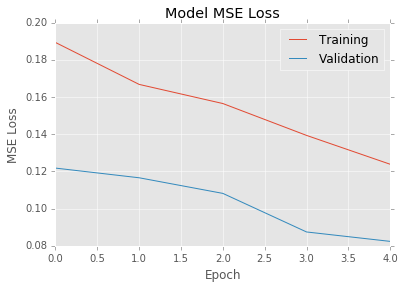

In [11]:
import matplotlib.pyplot as plt

print(history_obj.history.keys)

plt.plot(history_obj.history['loss'])
plt.plot(history_obj.history['val_loss'])
plt.title('Model MSE Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Save this trained model to an HDF5 file. It will be used by drive.py to test this model to generate steering angle for images from the simulator.

In [12]:
my_model.save('my_model.h5')

Try reloading the model and re-evaluate loss on validation data set

In [13]:
del my_model
from keras.models import load_model
my_model = load_model('my_model.h5')
my_model.evaluate_generator(generator=validation_generator, steps=validation_steps)

0.082372863002551991